In [1]:
import sys
import math
import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model

# Define paths
models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [2]:
def estimate_susceptibility(model, h_val, n_samples, k_steps, rng):
    dtype = next(model.parameters()).dtype

    with torch.no_grad():
        cond_batch_gen = torch.full((n_samples, 1), h_val, device=device, dtype=dtype)

        schedule_tensor = torch.tensor([1.0] * k_steps, device=device, dtype=dtype)
        samples = model.generate(cond_batch_gen, T_schedule=schedule_tensor, rng=rng)

    # create a batch of conditioning values for later gradient computation
    cond_batch_grad = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)

    # we evaluate log_score with gradients enabled on cond_batch
    log_psi = model.log_score(samples, cond_batch_grad)

    # since we parametrized log_psi with cond_batch the Jacobian has only main diagonal terms
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch_grad,
        grad_outputs=torch.ones_like(log_psi), # upstream gradient in VJP (scales each main diag term)
        create_graph=False
    )[0]

    # quadratic formula can be simplified to variance of the gradient: Var(d log_psi / dh)
    chi = torch.var(grads.squeeze(), unbiased=True)

    # estimate uncertainty of susceptibility via fourth central moment (kurtosis-aware variance)
    X = grads.squeeze()
    var_chi = (torch.mean(X**4) - torch.mean(X**2)**2) / n_samples

    chi_err = torch.sqrt(var_chi)
    return chi.item(), chi_err.item()

In [3]:
model_filename = "hyprbm_tfim_4x4_20000_suscept_20260204_005032.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

model, config = load_model(model_path, device)

h_support = config.get("h_support", [])
SIDE_LENGTH = int(math.sqrt(model.num_v))

print(f"Trained on support points: {h_support} \n")

ref_file = Path("tfim_4x4_suscept_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}")

Loading checkpoint: hyprbm_tfim_4x4_20000_suscept_20260204_005032.pt
Trained on support points: [1.0, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5] 

Loaded ED reference data from: tfim_4x4_suscept_ref.csv


Sweeping from h=1.0 to h=4.5 in 50 steps with 100000 Gibbs samples each...
h=1.64 | chi=0.3489 ± 0.0044
h=2.36 | chi=0.7619 ± 0.0112
h=3.07 | chi=0.3531 ± 0.0120
h=3.79 | chi=0.0464 ± 0.0040
h=4.50 | chi=0.0057 ± 0.0012


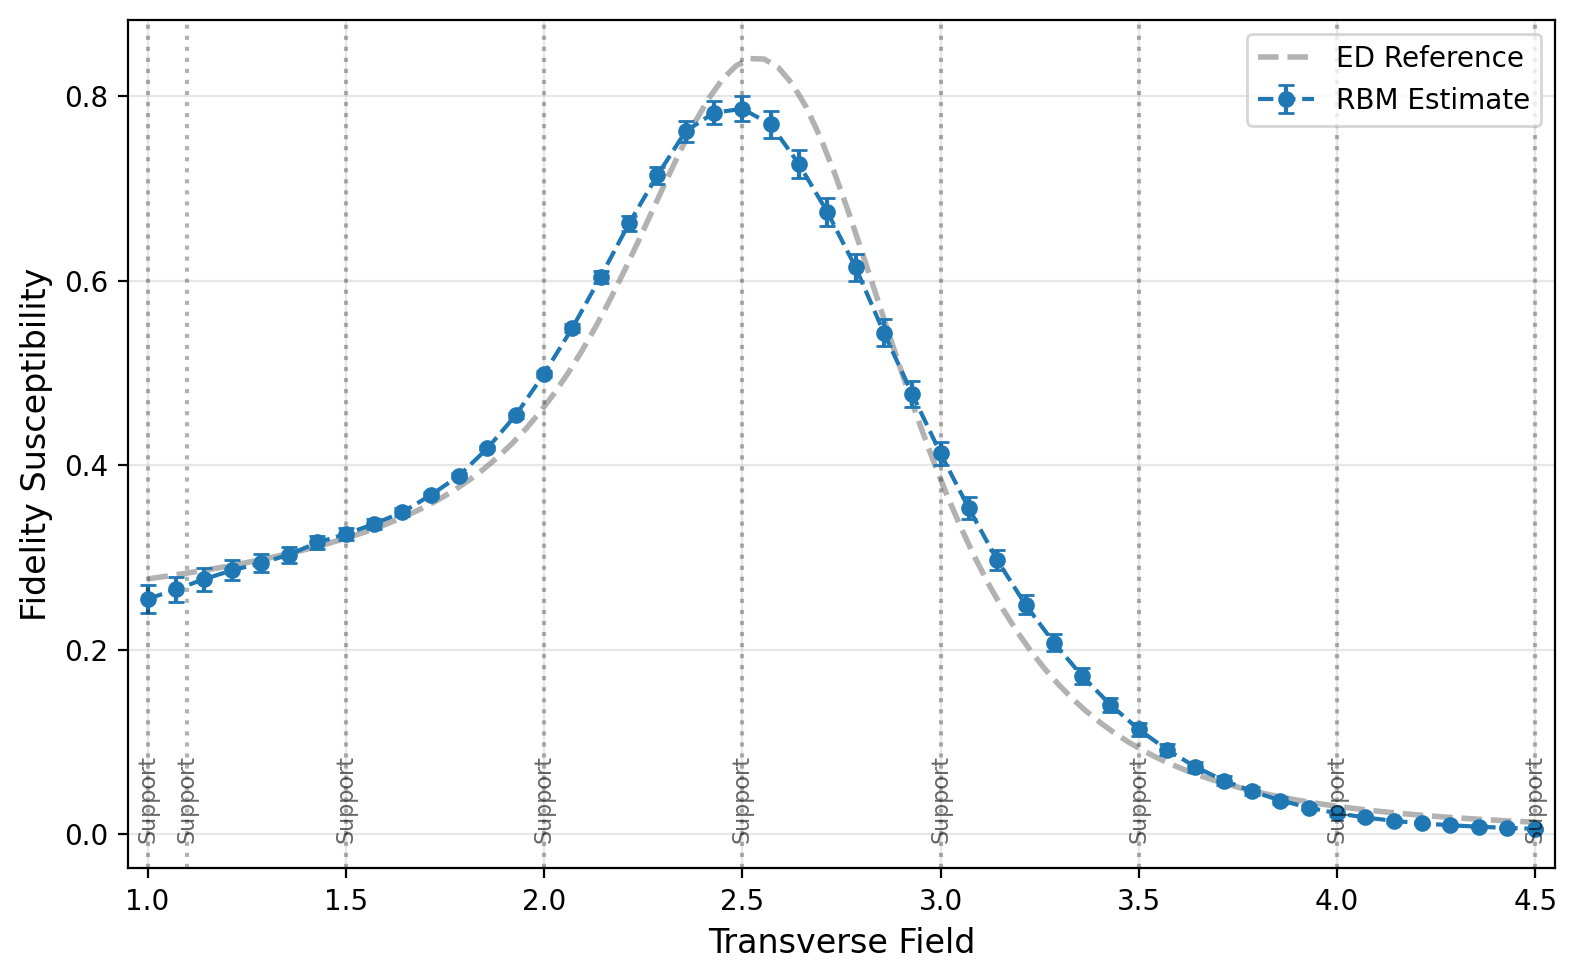

In [8]:
H_MIN = 1.0
H_MAX = 4.5
SWEEP_POINTS = 50
SAMPLES_EVAL = 100_000
K_STEPS_EVAL = 20

h_eval = np.linspace(H_MIN, H_MAX, SWEEP_POINTS)

print(f"Sweeping from h={H_MIN} to h={H_MAX} in {SWEEP_POINTS} steps with {SAMPLES_EVAL} Gibbs samples each...")

chi_values = []
chi_errors = []

for i, h in enumerate(h_eval):
    # instead of carrying over RNG state, we have Common Random Numbers (CRN)
    rng_point = torch.Generator(device=device).manual_seed(42)

    chi, chi_err = estimate_susceptibility(model, h, n_samples=SAMPLES_EVAL, k_steps=K_STEPS_EVAL, rng=rng_point)

    chi_values.append(chi)
    chi_errors.append(chi_err)

    if ((i + 1) % 10) == 0:
        print(f"h={h:.2f} | chi={chi:.4f} ± {chi_err:.4f}")

plt.figure(figsize=(8, 5), dpi=100)

plt.plot(ref_df["h"], ref_df["chi_F"], "--", color="gray", linewidth=2, alpha=0.6, label="ED Reference")
plt.errorbar(h_eval, chi_values, yerr=chi_errors, fmt="o--", markersize=5, capsize=3, label="RBM Estimate")

for h_supp in h_support:
    if H_MIN <= h_supp <= H_MAX:
        plt.axvline(h_supp, linestyle=":", color="k", alpha=0.3)
        plt.text(h_supp, 0.03, "Support", rotation=90, va="bottom", ha="center",
                 fontsize=8, alpha=0.6, transform=plt.gca().get_xaxis_transform())

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(H_MIN - 0.05, H_MAX + 0.05)
plt.tight_layout()
plt.show()

In [10]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results = np.column_stack((h_eval, chi_values))

file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_suscept_rbm_{timestamp}.csv"
save_path = results_dir / file_name

header = "h,chi_F"
np.savetxt(save_path, results, delimiter=",", header=header, comments="", fmt="%.6e")
print(f"Data saved to: {save_path}")

Data saved to: results/tfim_4x4_suscept_rbm_20260205_163618.csv
